/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Accuracy Table:

Sampling  Sampling1  Sampling2  Sampling3  Sampling4  Sampling5
Model                                                          
M1            95.03      92.59      96.89      96.30      94.67
M2            98.76      95.06      98.76      98.77      98.67
M3            93.17      88.89      96.89      92.59      94.67
M4            97.52      95.06      97.52      98.77      92.89
M5            78.88      75.31      77.02      80.25      76.89

Best Combination:

Model              M2
Sampling    Sampling4
Accuracy        98.77
Name: 16, dtype: object


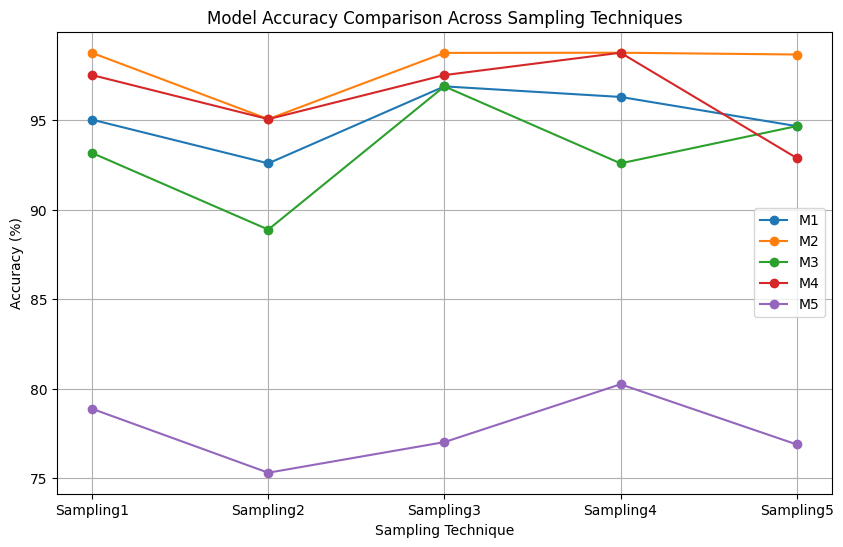

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler

df = pd.read_csv("/content/Creditcard_data.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

balanced_df = pd.concat([X_train_bal, y_train_bal], axis=1)

# Sampling1
sample1 = balanced_df.sample(frac=0.5, random_state=42)

# Sampling2
sample2 = balanced_df.iloc[::4, :]

# Sampling3
X_s = balanced_df.drop("Class", axis=1)
y_s = balanced_df["Class"]
X_str, _, y_str, _ = train_test_split(
    X_s, y_s,
    test_size=0.5,
    stratify=y_s,
    random_state=42
)
sample3 = pd.concat([X_str, y_str], axis=1)

# Sampling4
np.random.seed(42)
clusters = np.array_split(balanced_df.sample(frac=1, random_state=42), 4)
sample4 = clusters[1]

# Sampling5
sample5 = balanced_df.sample(frac=0.7, replace=True, random_state=42)

samples = {
    "Sampling1": sample1,
    "Sampling2": sample2,
    "Sampling3": sample3,
    "Sampling4": sample4,
    "Sampling5": sample5
}

models = {
    "M1": LogisticRegression(C=0.5, max_iter=1000),
    "M2": SVC(C=0.8, gamma='scale'),
    "M3": KNeighborsClassifier(n_neighbors=9),
    "M4": DecisionTreeClassifier(max_depth=4, random_state=42),
    "M5": GaussianNB()
}

results = []

for sample_name, sample_df in samples.items():

    X_sample = sample_df.drop("Class", axis=1)
    y_sample = sample_df["Class"]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_sample,
        y_sample,
        test_size=0.3,
        stratify=y_sample,
        random_state=42
    )

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    for model_name, model in models.items():

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        acc = round(accuracy_score(y_te, y_pred) * 100, 2)

        results.append({
            "Model": model_name,
            "Sampling": sample_name,
            "Accuracy": acc
        })

results_df = pd.DataFrame(results)

accuracy_table = results_df.pivot(index="Model", columns="Sampling", values="Accuracy")

print("\nAccuracy Table:\n")
print(accuracy_table)

best = results_df.loc[results_df["Accuracy"].idxmax()]
print("\nBest Combination:\n")
print(best)

plt.figure(figsize=(10,6))

for model in accuracy_table.index:
    plt.plot(accuracy_table.columns,
             accuracy_table.loc[model],
             marker='o',
             label=model)

plt.title("Model Accuracy Comparison Across Sampling Techniques")
plt.xlabel("Sampling Technique")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
